查询（自主提示）和键（非自主提示）之间的交互形成了注意力汇聚； 注意力汇聚有选择地聚合了值（感官输入）以生成最终的输出。 本节将介绍注意力汇聚的更多细节， 以便从宏观上了解注意力机制在实践中的运作方式。 具体来说，1964年提出的Nadaraya-Watson核回归模型 是一个简单但完整的例子，可以用于演示具有注意力机制的机器学习。

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

考虑下面这个回归问题：给定的成对的“输入—输出”数据集 $\{(x_1, y_1), \ldots, (x_n, y_n)\}$ ，如何学习 f 来预测任意新输入 x 的输出 $\hat{y} = f(x)$?

根据下面的非线性函数生成一个人工数据集，其中加入的噪声项为 $\epsilon$：

$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon$$

其中 $\epsilon$ 服从均值为0和标准差为0.5的正态分布。在这里生成了50个训练样本和50个测试样本。为了更好地可视化之后的注意力模式，需要将训练样本进行排序。

In [3]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

下面的函数将绘制所有的训练样本（样本由圆圈表示）， 不带噪声项的真实数据生成函数 f（标记为“Truth”）， 以及学习得到的预测函数（标记为“Pred”）

In [4]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

使用平均汇聚将得到下面的结果

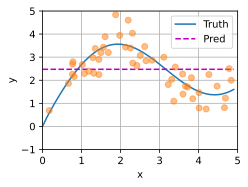

In [5]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

显然平均汇聚直接忽略了输入$x_i$

于是Nadaraya (Nadaraya,1964)和Watson (Watson ,1964)提出了一个更好的想法，根据输入的位置对输出 $y_i$ 进行加权：

$$f(x) = \sum_{i=1}^{n} \frac{K(x-x_i)}{\sum_{j=1}^{n} K(x-x_j)} y_i$$

其中 K 是核（kernel）。上面公式所描述的估计器被称为 Nadaraya-Watson核回归（Nadaraya-Watson kernel regression）。这里不会深入讨论核函数的细节，但受此启发，我们可以从注意力机制框架的角度重写该式，得到一个更加通用的注意力汇聚（attention pooling）公式：

$$f(x) = \sum_{i=1}^{n} \alpha(x, x_i) y_i$$

其中 x 是查询， $(x_i, y_i)$ 是键值对。比较这两个式子，注意力汇聚是 $y_i$ 的加权平均。将查询 x 和键 $x_i$ 之间的关系建模为 注意力权重（attention weight）$\alpha(x, x_i)$，这个权重将被分配给每一个对应值 $y_i$ 。对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布：它们是非负的，并且总和为1。

为了更好地理解注意力汇聚，下面考虑一个高斯核（Gaussian kernel），其定义为：

$$K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2})$$

将高斯核代入上面的公式中可以得到：

$$ 
\begin{align*}

f(x) &= \sum_{i=1}^{n} \alpha(x, x_i) y_i \\

     &= \sum_{i=1}^{n} \frac{\exp{(-\frac{1}{2}(x-x_i)^2)}}{\sum_{j=1}^{n} \exp{(-\frac{1}{2}(x-x_j)^2)}} y_i \\

     &= \sum_{i=1}^{n} \text{softmax} \left(-\frac{1}{2}(x-x_i)^2\right) y_i

\end{align*} 
$$

在该式中，如果一个键 $x_i$ 越是接近给定的查询 x ，那么分配给这个键对应值 $y_i$ 的注意力权重就会越大，也就“获得了更多的注意力”。

值得注意的是，Nadaraya-Watson核回归是一个非参数模型。因此，该式是 非参数的注意力汇聚（nonparametric attention pooling）模型。接下来，我们将基于这个非参数的注意力汇聚模型来绘制预测结果。从绘制的结果会发现新的模型预测线是平滑的，并且比平均汇聚的预测更接近真实。

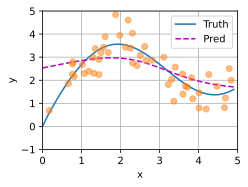

In [6]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询），每行对应一个查询，并与所有训练数据的x值进行比较
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))

# 计算注意力权重
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)

# 计算预测值
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

观察注意力的权重。 这里测试数据的输入相当于查询，而训练数据的输入相当于键。 因为两个输入都是经过排序的，因此由观察可知“查询-键”对越接近， 注意力汇聚的注意力权重就越高

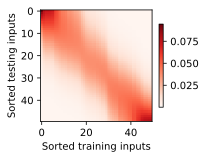

In [7]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

上面的模型是非参数的核回归

可以在距离的基础上乘上可学习参数来转变为带参数的回归模型

$$
\begin{align*}
f(x) &= \sum_{i=1}^{n} \alpha(x, x_i) y_i \\
&= \sum_{i=1}^{n} \frac{\exp \left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^{n} \exp \left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\
&= \sum_{i=1}^{n} \text{softmax} \left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.
\end{align*}
$$

为了更有效地计算小批量数据的注意力，我们可以利用深度学习开发框架中提供的批量矩阵乘法。

假设第一个小批量数据包含 n 个矩阵 $\mathbf{X}_1, \ldots, \mathbf{X}_n$ ，形状为 $a \times b$ ，第二个小批量包含 n 个矩阵 $\mathbf{Y}_1, \ldots, \mathbf{Y}_n$ ，形状为 $b \times c$ 。它们的批量矩阵乘法得到 n 个矩阵 $\mathbf{X}_1\mathbf{Y}_1, \ldots, \mathbf{X}_n\mathbf{Y}_n$ ，形状为 $a \times c$ 。因此，假定两个张量的形状分别是 (n, a, b) 和 (n, b, c) ，它们的批量矩阵乘法输出的形状为 (n, a, c) 。

In [ ]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

# torch.bmm是用于执行批量矩阵乘法的函数

torch.Size([2, 1, 6])

在注意力机制的背景中，我们可以使用小批量矩阵乘法来计算小批量数据中的加权平均值

In [9]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

现在就可以定义模型的带参数版本了

In [10]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))

        # 乘上权重w
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

将训练数据集变换为键和值用于训练注意力模型。 在带参数的注意力汇聚模型中， 任何一个训练样本的输入都会和除自己以外的所有训练样本的“键－值”对进行计算， 从而得到其对应的预测输出。

In [11]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))

# keys的形状:('n_train'，'n_train'-1)，每个训练样本对应的所有其他训练输入，过滤了对角线上的元素
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)，对应于keys的训练输出
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

训练带参数的注意力汇聚模型时，使用平方损失函数和随机梯度下降

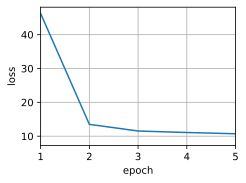

In [30]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=1.0)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(10):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

训练完带参数的注意力汇聚模型后可以发现： 在尝试拟合带噪声的训练数据时， 预测结果绘制的线不如之前非参数模型的平滑。

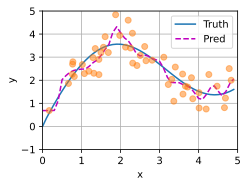

In [31]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

与非参数的注意力汇聚模型相比， 带参数的模型加入可学习的参数后， 曲线在注意力权重较大的区域变得更不平滑。

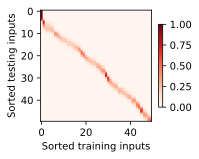

In [32]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')